# SC23x 
## Applied Predictive Modeling

 이번 스프린트 챌린지에서는 시카고에 있는 식당들의 정보와 해당 식당들의 위생 검사 결과에 관한 정보를 담은 데이터셋을 다루게 됩니다.

데이터셋에 관한 설명은 [PDF 문서](https://data.cityofchicago.org/api/assets/BAD5301B-681A-4202-9D25-51B2CAE672FF)를 참고해주시길 바랍니다.

#### 목표: 오늘 여러분은 Chicago시의 공중보건부에서 진행한 레스토랑들의 위생 검사 "불합격" 여부를 예측하는 모델을 만들어야 합니다.

여러분의 모델이 예측할 target은 `Inspection Fail` 칼럼입니다.   
칼럼 값은 아래와 같습니다:
- 식당이 위생 검사에 불합격한 경우: **1**
- 식당이 검사를 통과한 경우: **0**

In [434]:
# 데이터셋을 불러오기 위해 판다스 라이브러리를 불러옵니다
import pandas as pd

train_url = 'https://ds-lecture-data.s3.ap-northeast-2.amazonaws.com/food_inspection_sc23x/food_ins_train.csv'
test_url  = 'https://ds-lecture-data.s3.ap-northeast-2.amazonaws.com/food_inspection_sc23x/food_ins_test.csv'

# train, test 데이터셋을 불러옵니다
train = pd.read_csv(train_url)
test  = pd.read_csv(test_url)

# 데이터셋 확인
assert train.shape == (60000, 17)
assert test.shape  == (20000, 17)

# Part 1: 데이터 전처리 (Data Preprocessing)

## 1.1 데이터셋을 파악하기 위한 EDA를 진행하세요
> EDA를 하는 방식 및 라이브러리에 대한 제한은 없습니다. 단, **시간 분배**에 주의하세요.

In [435]:
# 이 곳에 답안을 작성해주시길 바랍니다

# 필요한 라이브러리 import

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
import datetime as dt

In [436]:
# 데이터 확인
train.head(2)

,Inspection ID,DBA Name,AKA Name,License #,Facility Type,Risk,Address,City,State,Zip,Inspection Date,Inspection Type,Violations,Latitude,Longitude,Location,Inspection Fail
0,2050629,MY SWEET STATION INC,MY SWEET STATION,2327223.0,Restaurant,Risk 1 (High),2511 N LINCOLN AVE,CHICAGO,IL,60614.0,2017-05-18,Canvass,NaN,41.927577,-87.651528,"(-87.65152817242594, 41.92757677830966)",0
1,2078428,OUTTAKES,RED MANGO,2125004.0,Restaurant,Risk 2 (Medium),10 S DEARBORN ST FL,CHICAGO,IL,60603.0,2017-08-14,Canvass,"34. FLOORS: CONSTRUCTED PER CODE, CLEANED, GOO...",41.881807,-87.629543,"(-87.62954311539407, 41.88180696006542)",0


In [437]:
# 데이터 확인
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60000 entries, 0 to 59999
Data columns (total 17 columns):
Inspection ID      60000 non-null int64
DBA Name           60000 non-null object
AKA Name           59283 non-null object
License #          59996 non-null float64
Facility Type      58573 non-null object
Risk               59976 non-null object
Address            60000 non-null object
City               59955 non-null object
State              59985 non-null object
Zip                59987 non-null float64
Inspection Date    60000 non-null object
Inspection Type    60000 non-null object
Violations         44130 non-null object
Latitude           59822 non-null float64
Longitude          59822 non-null float64
Location           59822 non-null object
Inspection Fail    60000 non-null int64
dtypes: float64(4), int64(2), object(11)
memory usage: 7.8+ MB


### Inspection ID : 중복 확인
결과: Unique한 값입니다. 이 feature는 컬럼을 단순히 분리하기 위한 목적이므로, 모델에 필요하지 않습니다.

In [438]:
print(train['Inspection ID'].nunique(),'\n')
print(train['Inspection ID'].value_counts())

60000 

2232318    1
60552      1
2050177    1
2185071    1
2387096    1
          ..
1956072    1
1353214    1
2145789    1
2268665    1
1966080    1
Name: Inspection ID, Length: 60000, dtype: int64


### DBA Name : 20175 개의 Category 존재하며 분포가 불규칙합니다.

In [439]:
print(train['DBA Name'].nunique())
print(train['DBA Name'].value_counts())

20175
SUBWAY                               830
DUNKIN DONUTS                        456
MCDONALD'S                           162
7-ELEVEN                             127
CHIPOTLE MEXICAN GRILL                99
                                    ... 
BERNIE'S RESTAURANT                    1
PASSION HOUSE COFFEE ROASTERS INC      1
GRAND SHELL                            1
H & D GROCERY                          1
JOE'S IMPORTS                          1
Name: DBA Name, Length: 20175, dtype: int64


Text(0.5, 1.0, 'DBA Name Counts - Unbalanced')

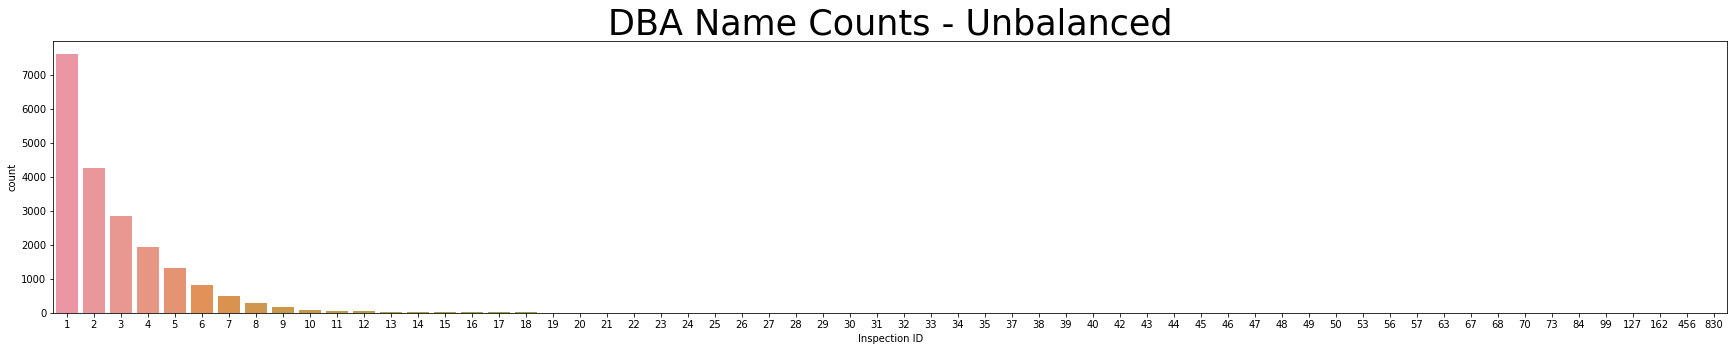

In [440]:
plot_df = train.groupby('DBA Name').count()['Inspection ID'].sort_values(ascending=False)

plt.figure(figsize=(30,5))
plot = sns.countplot(plot_df)
plt.title('DBA Name Counts - Unbalanced',fontsize=35)

### AKA Name : 19209 개의 Category 존재하며, 분포가 불규칙합니다.
결과: DBA Name과 상관계수가 0.9로 높아, 각 Feature들은 서로를 잘 설명합니다. 둘 중 한 개의 Feature는 삭제해도 무방합니다.

In [441]:
print(train['AKA Name'].nunique())
print(train['AKA Name'].value_counts())

19209
SUBWAY                1014
DUNKIN DONUTS          459
7-ELEVEN               238
MCDONALD'S             225
BURGER KING            130
                      ... 
CHARLY'S BURGERS         1
Tuscany Cafe             1
JW MARRIOT CHICAGO       1
ZEN & NOW                1
JOE'S IMPORTS            1
Name: AKA Name, Length: 19209, dtype: int64


Text(0.5, 1.0, 'AKA Name Counts - Unbalanced')

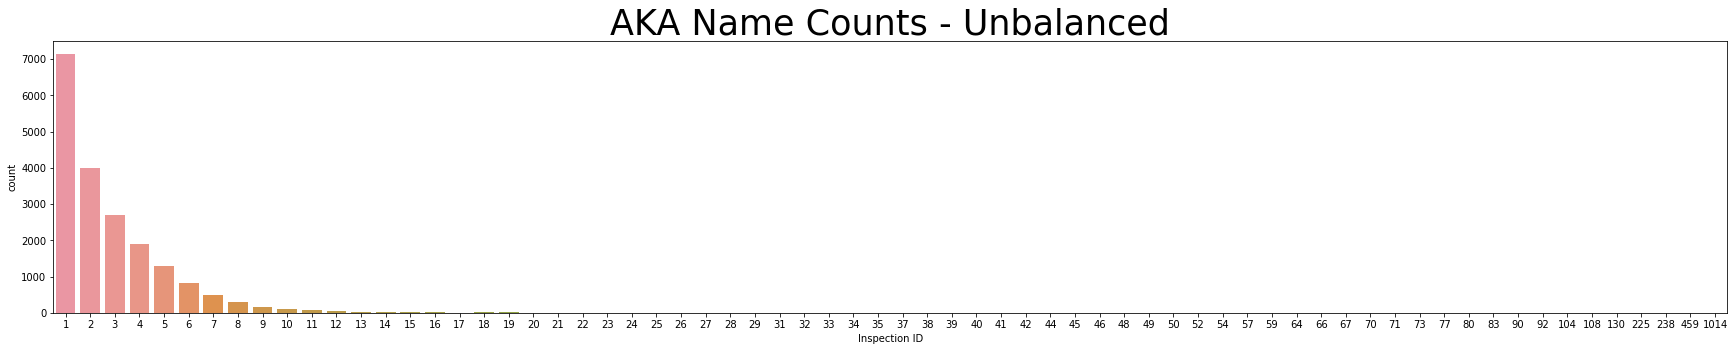

In [442]:
plot_df = train.groupby('AKA Name').count()['Inspection ID'].sort_values(ascending=False)

plt.figure(figsize=(30,5))
plot = sns.countplot(plot_df)
plt.title('AKA Name Counts - Unbalanced',fontsize=35)

#### AKA Name의 분포도와, DBA Name의 분포도가 비슷해보입니다. 실제로 이들이 연관성이 있는지 확인해보겠습니다.

In [443]:
# Groupby 그래프 결과, Feature 값이 매우 비슷하게 grouping 된 것을 알 수 있습니다.
pd.DataFrame(train.groupby(['AKA Name','DBA Name']).size().sort_values(ascending=False))

,,0
AKA Name,DBA Name,
SUBWAY,SUBWAY,829
DUNKIN DONUTS,DUNKIN DONUTS,411
MCDONALD'S,MCDONALD'S,151
7-ELEVEN,7-ELEVEN,126
CHIPOTLE MEXICAN GRILL,CHIPOTLE MEXICAN GRILL,99
...,...,...
PARK PLAZA RETIREMENT CENTER,PARK PLAZA RETIREMENT CENTER,1
PARK PACKING CO,PARK PACKING CO,1
PARK PACKING,"PARK PACKING OF CHICAGO, INC",1


In [444]:
# 라벨인코딩 후 상관계수값을 보며, 이들이 실질적으로 어느정도 관계가 있는지 분석해보겠습니다.
train['AKA Name']=train['AKA Name'].astype('str')

lb = LabelEncoder()
train['AKA Name_Label'] = lb.fit_transform(train['AKA Name'])
train['DBA Name_Label'] = lb.fit_transform(train['DBA Name'])

In [445]:
print('가장 상관계수가 높은 Feature: ', 
      train.corr()['AKA Name_Label'].sort_values(ascending=False).index[1],
      train.corr()['AKA Name_Label'].sort_values(ascending=False)[1].round(3))

가장 상관계수가 높은 Feature:  DBA Name_Label 0.901


### License # : Null 값이 존재하며, 25123 개의 Unique 값이 있습니다.

In [446]:
# 분포도가 상위 Features와 비슷한 양상을 띱니다.
print(train['License #'].nunique())
print(train['AKA Name'].value_counts())

25123
SUBWAY                1014
nan                    717
DUNKIN DONUTS          459
7-ELEVEN               238
MCDONALD'S             225
                      ... 
Tuscany Cafe             1
JW MARRIOT CHICAGO       1
ZEN & NOW                1
DON BETO'S GRILL         1
JOE'S IMPORTS            1
Name: AKA Name, Length: 19210, dtype: int64


In [447]:
# 따라서 상관관계를 분석한 결과, 약한 선형관계는 보이나 뚜렷한 선형관계를 보이지 않습니다.
train['License #_Label'] = lb.fit_transform(train['License #'])
train.corr()

,Inspection ID,License #,Zip,Latitude,Longitude,Inspection Fail,AKA Name_Label,DBA Name_Label,License #_Label
Inspection ID,1.000000,0.246442,-0.004473,0.042388,0.000846,-0.038647,-0.012544,-0.005656,0.390183
License #,0.246442,1.000000,-0.012310,-0.010526,0.035294,0.027671,-0.010555,-0.026697,0.897209
Zip,-0.004473,-0.012310,1.000000,0.179196,-0.379344,-0.004357,-0.000133,-0.002314,-0.015861
Latitude,0.042388,-0.010526,0.179196,1.000000,-0.423193,-0.021807,-0.005530,-0.000291,-0.010423
Longitude,0.000846,0.035294,-0.379344,-0.423193,1.000000,0.012028,0.012894,0.016599,0.032223
Inspection Fail,-0.038647,0.027671,-0.004357,-0.021807,0.012028,1.000000,-0.003394,-0.009732,0.031080
AKA Name_Label,-0.012544,-0.010555,-0.000133,-0.005530,0.012894,-0.003394,1.000000,0.900889,-0.009573
DBA Name_Label,-0.005656,-0.026697,-0.002314,-0.000291,0.016599,-0.009732,0.900889,1.000000,-0.025879
License #_Label,0.390183,0.897209,-0.015861,-0.010423,0.032223,0.031080,-0.009573,-0.025879,1.000000


### Facility Type : 366개의 Category가 존재하며, 비율이 Unbalanced 합니다.

366 

Restaurant                      39922
Grocery Store                    7863
School                           3605
Children's Services Facility      994
Bakery                            841
                                ...  
CLOTHING STORE                      1
TOBACCO STORE                       1
ICE CREAM PARLOR                    1
EVENT SPACE                         1
day spa                             1
Name: Facility Type, Length: 366, dtype: int64


Text(0.5, 1.0, 'Facility Type Counts - Unbalanced')

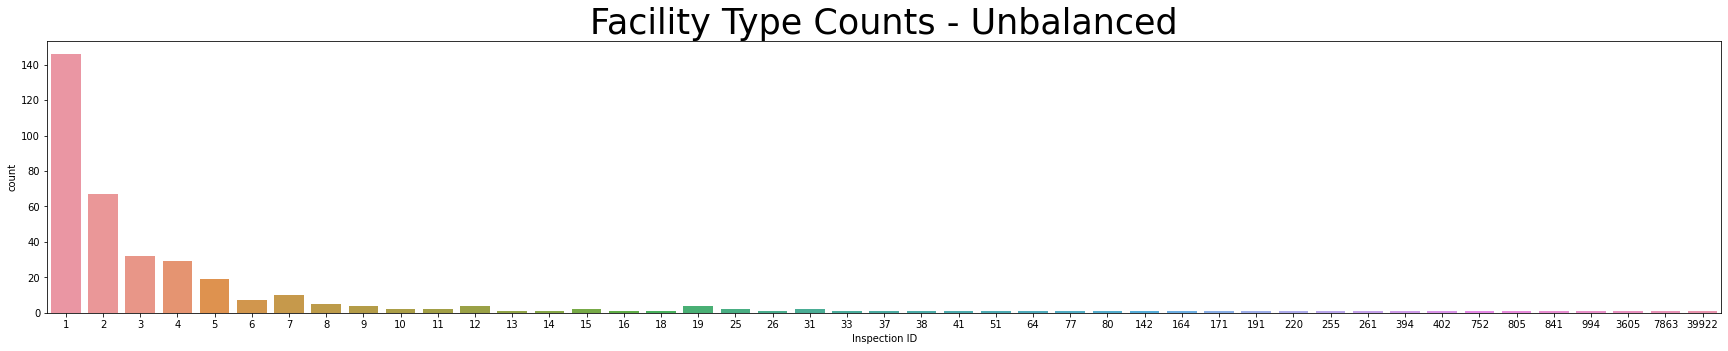

In [448]:
print(train['Facility Type'].nunique(),'\n')
print(train['Facility Type'].value_counts())

plot_df = train.groupby('Facility Type').count()['Inspection ID'].sort_values(ascending=False)

plt.figure(figsize=(30,5))
plot = sns.countplot(plot_df)
plt.title('Facility Type Counts - Unbalanced',fontsize=35)

In [449]:
# 상관분석 결과, 특별한 상관관계를 띠는 관계도 보이지 않습니다.
train['Facility Type_Label'] = lb.fit_transform(train['Facility Type'].astype('str'))
train.corr()['Facility Type_Label'].sort_values(ascending=False).head(3)

Facility Type_Label    1.000000
Latitude               0.087371
DBA Name_Label         0.049815
Name: Facility Type_Label, dtype: float64

### Risk : 상대적으로 적은 4개의 Category가 존재합니다.

In [450]:
print(train['Risk'].nunique(),'\n')
print(train['Risk'].value_counts())

4 

Risk 1 (High)      42839
Risk 2 (Medium)    11757
Risk 3 (Low)        5368
All                   12
Name: Risk, dtype: int64


### Address : 15244의 개별 Category 존재하며 타 Feature간의 상관관계도 크지 않습니다.
결과 : 지역의 범주를 넓혀, 대분류로 위치를 묶어봅니다. ( '대분류 주소' 라는 새로운 Feature를 추출해야 합니다.)

In [451]:
# 15244개의 Category가 존재하며, 타 Features 에 대한 상관관계도 크지 않습니다.
print(train['Address'].nunique(),'\n')
train['Address_Label'] = lb.fit_transform(train['Address'])
print(train.corr()['Address_Label'].sort_values(ascending=False).head(2))

15244 

Address_Label    1.000000
Zip              0.039026
Name: Address_Label, dtype: float64


In [452]:
# 값이 일정한 형식을 띱니다. 대분류 혹은 중분류까지 묶을 수 있을 것으로 보입니다.
train['Address'].unique().tolist()

['2511 N LINCOLN AVE ',
 '10 S DEARBORN ST FL ',
 '225 N MICHIGAN AVE ',
 '1863 N CLYBOURN AVE ',
 '1700 S MICHIGAN AVE ',
 '2824 W ARMITAGE AVE ',
 '3223 W FRANKLIN BLVD ',
 '5115 S KEDZIE AVE ',
 '123 E 51ST ST ',
 '6700 N WHIPPLE ',
 '7117 N CLARK ST ',
 '1911 S MICHIGAN AVE ',
 '1508-1510 N WELLS ST ',
 '1415 W IRVING PARK RD ',
 '8307 S DR MARTIN LUTHER KING JR DR ',
 '4640-4642 N KEDZIE AVE ',
 '11600-11604 S MICHIGAN AVE ',
 '11601 W TOUHY AVE ',
 '66 E WACKER PL ',
 '2401-2403 N WESTERN AVE ',
 '7338 S STONY ISLAND AVE ',
 '2245 W JACKSON BLVD ',
 '2855 N MILWAUKEE AVE ',
 '305-309 N CICERO AVE ',
 '1934 W 79TH ST ',
 '324 N Leavitt ',
 '4600 W BELMONT AVE ',
 '1026 E 67TH ST ',
 '6349 N CALIFORNIA AVE ',
 '5804 S WESTERN AVE ',
 '10100 S HALSTED ST ',
 '333 S WABASH AVE ',
 '5547 N KENMORE AVE ',
 '305-307 W LAKE ST ',
 '4243 W NORTH AVE ',
 '2601 W LELAND AVE ',
 '4934 S Wabash (45E) (C/Shabazz) ',
 '1206 - 1208 W WEBSTER AVE ',
 '2343 W TAYLOR ST ',
 '236 N PULASKI RD ',
 '1

In [453]:
# 대분류 결과, 주소의 맨 마지막 단위로, 487개의 카테고리로 묶을 수 있다는 것을 확인했습니다.

print( train['Address'].str.split(' ').str[-2].nunique() )
print( train['Address'].str.split(' ').str[-3].nunique() )
print( train['Address'].str.split(' ').str[-4].nunique() )
print( train['Address'].str.split(' ').str[-5].nunique() )

487
983
884
6270


### City : 31개의 Category가 있음을 확인했습니다. Unbalanced - 시카고 City 가 압도적 높은 비율입니다.
결과 : City는 Address 혹은 우편번호와 상관관계가 있을 수 있음을 예상할 수 있습니다. 상관관계 확인 후, Feature를 정리해야 합니다.

In [454]:
# 데이터를 확인해본 결과, 오류가 존재합니다. 오타를 없애 정제를 시도합니다.
train['City'].value_counts()

CHICAGO                 59771
Chicago                    81
chicago                    36
CCHICAGO                    9
ELK GROVE VILLAGE           5
INACTIVE                    4
SCHAUMBURG                  4
CICERO                      4
MAYWOOD                     3
CHicago                     3
HIGHLAND PARK               2
CHICAGOCHICAGO              2
SKOKIE                      2
OAK PARK                    2
SUMMIT                      2
CALUMET CITY                2
BOLINGBROOK                 1
PLAINFIELD                  1
CHICAGOI                    1
LAKE ZURICH                 1
NEW HOLSTEIN                1
WHEATON                     1
BRIDGEVIEW                  1
alsip                       1
STREAMWOOD                  1
CHCICAGO                    1
EVANSTON                    1
WORTH                       1
ELMHURST                    1
CHICAGO.                    1
EAST HAZEL CREST            1
312CHICAGO                  1
GRIFFITH                    1
ROSEMONT  

In [455]:
# City 값을 모두 대문자(+기호 없애기)로 동일하게 변경하는 for문
train['City']=train['City'].astype('str')

for i in range(0,len(train)):
    train['City'][i] = train['City'][i].upper().replace('.','')

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [456]:
# 시카고의 TYPO 해결하는 fcr 문
typo = ['CCHICAGO','CHICAGOCHICAGO','CHICAGOI','CHCICAGO','312CHICAGO']
for i in typo: train['City'] = train['City'].replace(i,'CHICAGO')

In [457]:
train['City'].value_counts()

CHICAGO                 59906
NAN                        45
ELK GROVE VILLAGE           5
INACTIVE                    4
SCHAUMBURG                  4
CICERO                      4
MAYWOOD                     3
SKOKIE                      2
OAK PARK                    2
HIGHLAND PARK               2
CALUMET CITY                2
SUMMIT                      2
ELMHURST                    1
PLAINFIELD                  1
GRIFFITH                    1
BRIDGEVIEW                  1
ALSIP                       1
WHEATON                     1
BOLINGBROOK                 1
LAKE ZURICH                 1
WORTH                       1
STREAMWOOD                  1
BANNOCKBURNDEERFIELD        1
EVANSTON                    1
CHARLES A HAYES             1
NEW HOLSTEIN                1
ROSEMONT                    1
NILES NILES                 1
WESTMONT                    1
BURNHAM                     1
EAST HAZEL CREST            1
Name: City, dtype: int64

In [458]:
# 오류 해결 결과, 31개의 카테고리가 있음을 확인
train['City'].nunique()

31

### State : 3개의 Category이나, IL 값이 압도적으로 많기 때문에, 나머지 값(WI,IN)을 Outlier 처리합니다.
결과:이렇게 하면 State가 제공하는 정보가 크지 않으므로, 이 Feature 자체를 삭제하는 것이 올바르다고 판단합니다.

In [459]:
train['State'].value_counts()

IL    59983
WI        1
IN        1
Name: State, dtype: int64

In [460]:
# 각각 1개의 값을 가진 WI, IN이 어떤 값인지 확인 - NaN 값이 많고, 각각 1개씩으로 이상치로 판단
train[(train['State']=='WI') | (train['State']=='IN')]

,Inspection ID,DBA Name,AKA Name,License #,Facility Type,Risk,Address,City,State,Zip,...,Violations,Latitude,Longitude,Location,Inspection Fail,AKA Name_Label,DBA Name_Label,License #_Label,Facility Type_Label,Address_Label
18316,2301197,ICE CREAM ON WHEELS,ICE CREAM ON WHEELS,2678115.0,Mobile Food Dispenser,Risk 3 (Low),2011 N GRIFFIN BLVD,GRIFFITH,IN,46319.0,...,5. PROCEDURES FOR RESPONDING TO VOMITING AND D...,NaN,NaN,NaN,1,8019,8441,24434,218,3625
50966,2293796,THE COOKIE CRATE,THE COOKIE CRATE,2652809.0,Shared Kitchen User (Long Term),Risk 2 (Medium),N2660 HAYTON RD,NEW HOLSTEIN,WI,53061.0,...,"3. MANAGEMENT, FOOD EMPLOYEE AND CONDITIONAL E...",NaN,NaN,NaN,0,17088,17935,24107,294,15243


### 	Zip	(우편번호) : 86개의 Category를 32개로 범주화 합니다.
결과 : City의 Category 개수와 어느정도 비슷합니다. 이들의 상관관계를 확인해보아야 합니다.

In [461]:
#우편번호의 Category는 86개이며, null값이 존재합니다.
print(train['Zip'].nunique())

print(train['Zip'].unique())

86
[60614. 60603. 60601. 60616. 60647. 60624. 60632. 60615. 60645. 60626.
 60610. 60613. 60619. 60625. 60628. 60666. 60649. 60612. 60618. 60644.
 60620. 60641. 60637. 60659. 60636. 60604. 60640. 60606. 60639. 60607.
 60617. 60654. 60611. 60605. 60621. 60622. 60609. 60651. 60638. 60661.
 60643. 60657. 60804. 60634. 60653. 60608. 60623. 60629. 60652. 60646.
 60630. 60660. 60631. 60827. 60602. 60642. 60655. 60714. 60707. 60153.
 60633. 60656.    nan 60201. 60007. 60302. 60018. 60047. 60429. 60076.
 46319. 60627. 60193. 60440. 60035. 60126. 60585. 60189. 60409. 60107.
 60501. 60455. 60559. 60482. 53061. 60015. 60805.]


In [462]:
#Category 범주화를 시켜줍니다. (값이 너무 하나의 value로 치우치지 않을 정도로 묶어줍니다.)

print(train['Zip'].round(-1).nunique(),'\n')
print(train['Zip'].round(-1).value_counts())
train['Zip']=train['Zip'].round(-1)

32 

60620.0    13681
60610.0    13197
60640.0     9250
60630.0     7239
60650.0     6574
60660.0     5648
60600.0     3225
60670.0      762
60710.0      320
60830.0       49
60010.0        5
60800.0        5
60190.0        5
60150.0        3
60500.0        2
60040.0        2
60020.0        2
60080.0        2
60410.0        2
60300.0        2
60050.0        1
60110.0        1
60130.0        1
53060.0        1
60460.0        1
60200.0        1
60430.0        1
60440.0        1
60480.0        1
60560.0        1
60580.0        1
46320.0        1
Name: Zip, dtype: int64


### Inspection Date : 날짜 별 데이터 분포는 각각 차이가 존재합니다.

In [463]:
# dtype를 datetime으로 바꿉니다.
train['Inspection Date']=pd.to_datetime(train['Inspection Date'])

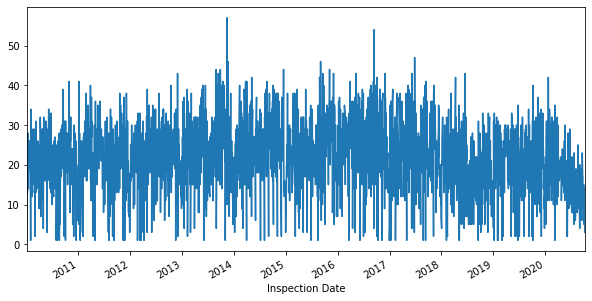

In [466]:
# 연도 별 데이터 개수의 차이가 존재하는지 확인합니다. 그 결과, 2016년도까지 증가하다가 2020년 급감함을 알 수 있습니다.
# 시계열 데이터의 정보가 Unbalanced 합니다.
plt.figure(figsize=(10,5))
train.groupby(['Inspection Date']).count()['Inspection Fail'].plot()

### 	Inspection Type : Category 종류가 다양하며, 오류가 존재합니다.

In [468]:
print(train['Inspection Type'].nunique(),'\n')
print(train['Inspection Type'].value_counts())

55 

Canvass                                      31913
License                                       7876
Canvass Re-Inspection                         6436
Complaint                                     5544
License Re-Inspection                         2641
Complaint Re-Inspection                       2234
Short Form Complaint                          2046
Suspected Food Poisoning                       253
Consultation                                   192
Tag Removal                                    175
License-Task Force                             168
Recent Inspection                              121
Out of Business                                 79
Task Force Liquor 1475                          79
Suspected Food Poisoning Re-inspection          50
Complaint-Fire                                  39
Short Form Fire-Complaint                       35
No Entry                                        22
Special Events (Festivals)                      15
Complaint-Fire Re-inspecti

### 	Violations	

In [469]:
train['Violations']

0                                                      NaN
1        34. FLOORS: CONSTRUCTED PER CODE, CLEANED, GOO...
2        30. FOOD IN ORIGINAL CONTAINER, PROPERLY LABEL...
3        33. FOOD AND NON-FOOD CONTACT EQUIPMENT UTENSI...
4                                                      NaN
                               ...                        
59995    55. PHYSICAL FACILITIES INSTALLED, MAINTAINED ...
59996    34. FLOORS: CONSTRUCTED PER CODE, CLEANED, GOO...
59997    33. FOOD AND NON-FOOD CONTACT EQUIPMENT UTENSI...
59998                                                  NaN
59999    3. MANAGEMENT, FOOD EMPLOYEE AND CONDITIONAL E...
Name: Violations, Length: 60000, dtype: object

### Latitude : 데이터의 분포가 정규분포 형태는 아닙니다. 그러나, 한 지점을 중심으로 데이터의 분포도가 변화합니다.
결과 : 그룹을 나눠 데이터의 분포도에 맞게 그룹핑을 시도해보는 것에 대한 아이디어를 얻을 수 있습니다.

In [470]:
# 빈 값이 존재합니다. 비율은 3% 이므로, 결측치 처리는 dropna()를 진행해도 좋습니다.
((train['Latitude'].isnull().sum()/len(train))).round(3)

0.003

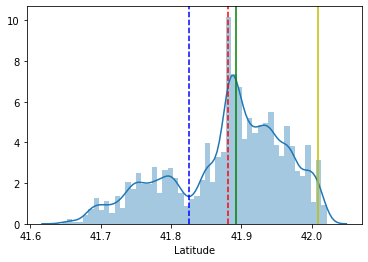

In [471]:
# 우선, distplot을 확인하기 위해, 빈 값을 제거한 뒤, 해당 값에 대한 분포도를 그립니다.
# 정규분포형태는 아닙니다. 그러나, mean 값을 기점으로 그래프의 개수가 나뉘며 & 약 41.825 값을 중심으로 데이터의 분포도가 변화합니다.

a_plot= sns.distplot(train.dropna(subset=['Latitude'])['Latitude'])
a_plot.axvline(train['Latitude'].mean(),color= 'red', linestyle='--')
a_plot.axvline(train['Latitude'].median(),color= 'g', linestyle='-')
a_plot.axvline(train['Latitude'].mode().values,color= 'y', linestyle='-')
a_plot.axvline(41.825,color= 'b', linestyle='--')

### Longitude	

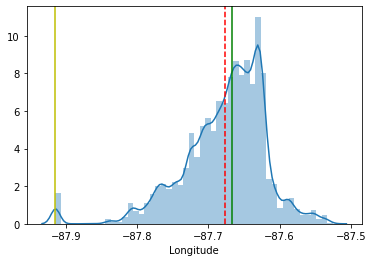

In [472]:
# 어느정도 정규 분포의 형태를 띠고 있지만, 이상치가 존재하며 & 왼쪽으로 치우쳐져 있습니다.

a_plot= sns.distplot(train.dropna(subset=['Longitude'])['Longitude'])
a_plot.axvline(train['Longitude'].mean(),color= 'red', linestyle='--')
a_plot.axvline(train['Longitude'].median(),color= 'g', linestyle='-')
a_plot.axvline(train['Longitude'].mode().values,color= 'y', linestyle='-')

### Location	: X 좌표와 Y 좌표를 나누었을 때, X는 Longtitude, Y는 Latitude와 100% 선형관계를 보입니다.
결과 : 해당 Location Feature는 ongtitude, Latitude가 완벽히 설명할 수 있으므로 제거합니다.

In [473]:
train['Location'] = train['Location'].str.lstrip('(')
train['Location'] = train['Location'].str.rstrip(')')
train['Location_X'],train['Location_Y'] = train['Location'].str.split(',').str[0].astype('float'),train['Location'].str.split(',').str[1].astype('float')

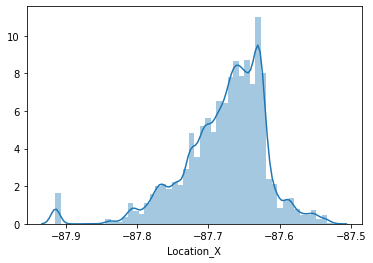

In [474]:
# X 좌표의 형태는 Longitude 와 유사합니다. 상관관계 확인이 필요합니다.
sns.distplot(train.dropna(subset=['Location_X'])['Location_X'].astype('float'))

In [475]:
# 완벽히 일치하므로 각 값은 서로의 Feature가 대변할 수 있습니다.
train.corr()['Location_X'].sort_values(ascending=False).head(2)

Longitude     1.0
Location_X    1.0
Name: Location_X, dtype: float64

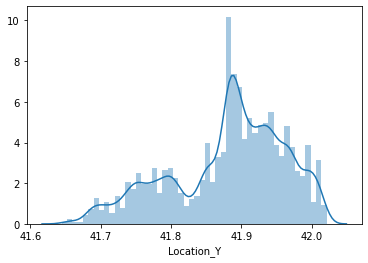

In [476]:
# Y 좌표의 형태는 Latitude와 비슷합니다. 상관관계를 확인해보아야 합니다.
sns.distplot(train.dropna(subset=['Location_Y'])['Location_Y'].astype('float'))

In [477]:
# 완벽히 일치하므로 각 값은 서로의 Feature가 대변할 수 있습니다.
train.corr()['Location_Y'].sort_values(ascending=False).head(2)

Location_Y    1.0
Latitude      1.0
Name: Location_Y, dtype: float64

### Inspection Fail : Target값이며, 약 3:1 비율로 Unbalanced 입니다.

결과 : 분류 시, ROC, AUC 등 정확도 외 평가지표를 활용합니다.

0    48284
1    11716
Name: Inspection Fail, dtype: int64 



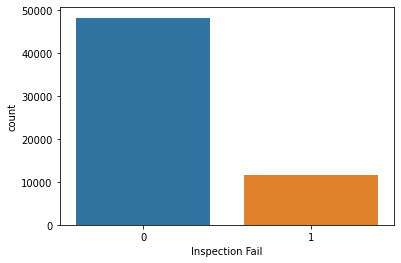

In [478]:
print(train['Inspection Fail'].value_counts(),'\n')
sns.countplot(train['Inspection Fail'])

## 1.2 EDA의 결과를 토대로 Feature Engineering 및 Preprocessing을 진행하세요
> 새로운 feature를 만드는 작업뿐만이 아니라, 필요한 feature가 적절한 데이터 타입을 가지고 있지 않다면 변환합니다

In [479]:
# 이 곳에 답안을 작성해주시길 바랍니다

# Part 2: 모델링 (Modeling)

## 2.1 검증 방식 (Cross-validation / Hold-out Validation)을 정한 후 데이터셋을 목적에 맞게 분할하세요

In [480]:
# 이 곳에 답안을 작성해주시길 바랍니다

## 2.2 모델 학습을 위한 파이프라인을 구축 후 학습(fit)까지 진행하세요
> 모델은 scikit-learn, xgboost, lightgbm 등 어떤 라이브러리를 사용하셔도 괜찮지만 특정 라이브러리는 **설치 및 설정에 시간이 소요되는 점**을 감안하시기 바랍니다

In [481]:
# 이 곳에 답안을 작성해주시길 바랍니다

## 2.3 테스트셋의 ROC / AUC 검증 점수를 예측합니다
> 제작한 모델을 활용해서 테스트셋의 **확률**을 예측하세요 (`ROC/AUC 검증 점수`를 **0.65 혹은 그 이상** 달성한다면 매우 훌륭한 모델입니다). 명시된 성능이 나오지 않았더라도 이 문제에 모든 시간을 소요하시면 안됩니다 (점수가 안나오는 경우 여러분이 구축한 파이프라인 모델링 및 모델링 과정으로 평가합니다)

In [482]:
# 이 곳에 답안을 작성해주시길 바랍니다

## 2.4 하이퍼 파라미터 튜닝을 통해서 모델을 개선하세요
> `RandomSearchCV`, `GridSearchCV` 등을 활용해서 모델의 성능을 개선합니다. 범위 설정에 따라 시간이 매우 소요될 수 있습니다.

In [483]:
# 이 곳에 답안을 작성해주시길 바랍니다

# Part 3: 시각화 (Visualization)

> 모델의 해석을 위한 시각화를 해주세요. 아래의 제시 된 종류 중 **2가지**를 선택하세요 (시각화에서 가장 중요한 것은 **여러분의 해석**입니다):
> - Permutation Importances
> - Partial Dependence Plot, 1 feature isolation
> - Partial Dependence Plot, 2 features interaction
> - Shapley Values (SHAP)

In [ ]:
# 이 곳에 답안을 작성해주시길 바랍니다